In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.vit import ViT
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/vit")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(0, 1),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [ ]:
model = ViT(
    output_size=num_class,
    patch_size=int(IMAGE_SIZE / 14), # for 16x16, you can just write 16
    size="base",
).to(device)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
ViT                                                               --
├─ModuleDict: 1-1                                                 --
│    └─PositionEncoding: 2-1                                      --
│    └─Embedding: 2-2                                             1,280
│    └─Sequential: 2-3                                            --
│    │    └─Conv2d: 3-1                                           2,102,912
│    │    └─Flatten: 3-2                                          --
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-4                                            --
│    │    └─TransformerEncoderLayer: 3-3                          99,584
│    │    └─TransformerEncoderLayer: 3-4                          99,584
│    │    └─TransformerEncoderLayer: 3-5                          99,584
│    │    └─TransformerEncoderLayer: 3-6                          99,584
│  

# training

In [ ]:
epoches = 10

In [ ]:
trainer = ClassificationTrainer(epoches, device)

In [ ]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1) # TODO: try lr and lambda

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [16:36<00:00,  1.64it/s]


epoch 1 : 0.06735348385191707


100%|██████████| 1636/1636 [02:35<00:00, 10.49it/s]


epoch 2 : 0.03529236331572961


100%|██████████| 1636/1636 [02:45<00:00,  9.91it/s]


epoch 3 : 0.031090072152366484


100%|██████████| 1636/1636 [02:46<00:00,  9.80it/s]


epoch 4 : 0.029231518629396422


100%|██████████| 1636/1636 [02:32<00:00, 10.74it/s]


epoch 5 : 0.02822173205329547


100%|██████████| 1636/1636 [02:26<00:00, 11.19it/s]


epoch 6 : 0.027486106816310352


100%|██████████| 1636/1636 [02:35<00:00, 10.54it/s]


epoch 7 : 0.02686861635147068


100%|██████████| 1636/1636 [02:41<00:00, 10.16it/s]


epoch 8 : 0.026512196819209164


100%|██████████| 1636/1636 [02:38<00:00, 10.31it/s]


epoch 9 : 0.025931197366037367


100%|██████████| 1636/1636 [02:31<00:00, 10.82it/s]

epoch 10 : 0.025657407491420075


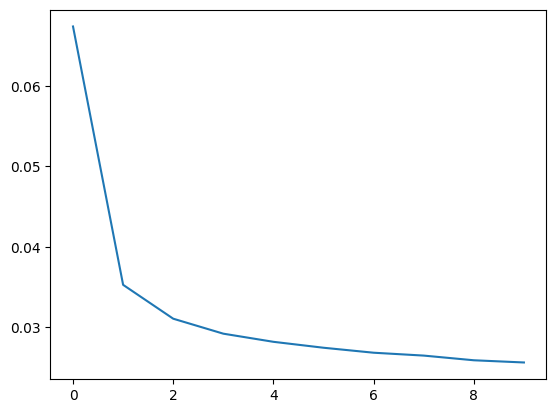

In [19]:
plt.plot(training_loss)

# inference

In [23]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [24]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [25]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [26]:
evaluator = ClassificationEvaluator(num_class, device)

In [27]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [02:05<00:00, 13.07it/s]

[[ 737  476   80 1099  198  607  547  109  919   91]
 [ 124  753   66  491   66   80  612   40  361   30]
 [ 126  241   83  308   16  116  308   16  211   21]
 [  93  200   29  732   77   98  122   48  676   37]
 [ 371  299   50  888  287  220  363   48  511   61]
 [ 230  176   25  388   38  340  125   21  293   32]
 [  75  309   29  281   37   60  772   41  231   31]
 [ 144  221   27  310   37  116  437  198  303   27]
 [ 560  282   47 1216   80  718  204   48 1614   52]
 [ 163  188   33  449   45  186  148   19  531  100]]


In [31]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.15155253958461856
cavallo   : 0.28707586732748763
elefante  : 0.05739972337482711
farfalla  : 0.3465909090909091
gallina   : 0.09264041316978695
gatto     : 0.2038369304556355
mucca     : 0.4137191854233655
pecora    : 0.1087912087912088
ragno     : 0.33478531425015556
scoiattolo: 0.05370569280343716


In [32]:
per_class_acc.mean()

0.20500977842714319

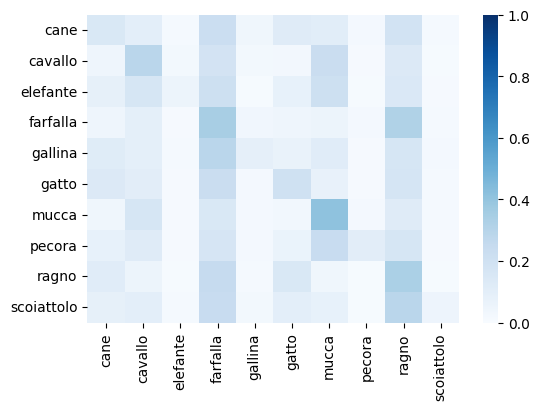

In [30]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [20]:
model_path = artifact_path / f'vit.{model.embed_dim}.{model.patch_size}x{model.patch_size}.pth'

In [21]:
torch.save(model.state_dict(), model_path)

In [22]:
get_file_size(model_path)

'10.34MiB'

In [16]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>